# Preamble

In [1]:
dir_home = '../'
dir_data = dir_home+'data/'
dir_fig = dir_home+'figs/'
import sys
sys.path.insert(0, dir_home)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from preamble import *
from my_units import *
from signal_functions import *
from param_card import *

# Sensitivity

## Fundamental scan

### 4cm

In [2]:
l = 4 * CentiMeter; N_series = 1; N_parallel = 1; 

omega_0 = np.abs(fn_omega_n(l,v,1)); 
omega_res = fn_omega_res(l,v,h_11,c_11,beta_11);

C_c = fn_C_crystal_TE_c(l,a,b,beta_11)
C_1_fid = np.real(C_c)
L_1_fid = 1/(omega_0**2 * np.real(C_c))

t_int = 1 * Year
N_shots = 10**4
t_shot = t_int / N_shots
Q_a = (235 / np.sqrt(2) * KiloMeter / Second)**(-2); print('Q_a =',Q_a)

Q_a = 3254885.2104547503


In [3]:
vec_L_1 = L_1_fid * np.logspace(-1,2,3000)
vec_C_1 = C_1_fid * np.asarray([0.1,10])
arr_omega_opt = np.ones((len(vec_L_1),len(vec_C_1))) * np.nan; 

for i,L_1 in enumerate(vec_L_1):
    L_1_n = L_1 * (1 - 1j * eps_L_1)
    for j,C_1 in enumerate(vec_C_1):
        def fun_Z(omega_frac):
            return np.imag(fn_Z_total(omega_frac * omega_0,l,v,a,b,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1_n, L_2, k_f,N_series,N_parallel))
        if j==0:
            try:
                arr_omega_opt[i,j] = brentq(f=fun_Z,a=(2*omega_res-omega_0)/omega_0,b=(1-1e-5),xtol=1e-12)
            except ValueError:
                pass
        elif j==1:
            try:
                arr_omega_opt[i,j] =  brentq(f=fun_Z,a=1+1e-5,b=(3*omega_0-2*omega_res)/omega_0,xtol=1e-12)
            except ValueError:
                pass
            
fn_L_1_down = interp1d(omega_0 * arr_omega_opt[np.isfinite(arr_omega_opt[:,0]),0],vec_L_1[np.isfinite(arr_omega_opt[:,0])],bounds_error=False,fill_value=np.nan)
fn_L_1_up = interp1d(omega_0 * arr_omega_opt[np.isfinite(arr_omega_opt[:,1]),1],vec_L_1[np.isfinite(arr_omega_opt[:,1])],bounds_error=False,fill_value=np.nan)

vec_omega_branch_down = omega_0 * np.linspace(np.nanmin(arr_omega_opt[:,0]),np.nanmax(arr_omega_opt[:,0]),int(N_shots/2))
vec_omega_branch_up = omega_0 * np.linspace(np.nanmin(arr_omega_opt[:,1]),np.nanmax(arr_omega_opt[:,1]),int(N_shots/2))
vec_omega_plot = np.linspace(3*omega_res-2*omega_0,4*omega_0-3*omega_res,1000)

vec_L_1_branch_down = fn_L_1_down(vec_omega_branch_down)
vec_L_1_branch_up = fn_L_1_up(vec_omega_branch_up)
vec_L_1_branch = np.concatenate([vec_L_1_branch_down,vec_L_1_branch_up])

In [4]:
vec_theta_sens_plot = np.zeros(vec_omega_plot.shape)
for i,L_1 in enumerate(tqdm(vec_L_1_branch)):
    L_1_n = L_1 * (1 - 1j * eps_L_1)
    if i < N_shots//2:
        C_1 = vec_C_1[0]
    else:
        C_1 = vec_C_1[1]
    vec_theta_sens_shot = fn_theta_sens_opt(t_shot,Q_a,T,vec_omega_plot,l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid,L_i, k_i,C_1,L_1_n,L_2,k_f,eta,
                                        T_2,mu_N,n_N,xi_11,zeta_11,P_nuc,N_series,N_parallel)
    if vec_theta_sens_shot[0] > 0:
        vec_theta_sens_plot += vec_theta_sens_shot**(-4)
    else:
        print(',',end='')
vec_theta_sens_plot = vec_theta_sens_plot**(-1/4)

100%|██████████| 10000/10000 [00:04<00:00, 2106.70it/s]


In [5]:
omega = (omega_res + omega_0)/2
L_1_n = fn_L_1_down(omega) * (1 - 1j * eps_L_1)
C_1 = vec_C_1[0]
vec_theta_sens_shot = fn_theta_sens_opt(t_shot,Q_a,T,vec_omega_plot,l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid,L_i, k_i,C_1,L_1_n,L_2,k_f,eta,
                                    T_2,mu_N,n_N,xi_11,zeta_11,P_nuc,N_series,N_parallel)

In [6]:
vec_G_aee_sens_shot = vec_theta_sens_shot / ThetaAxion * xi_11 / xi_11_G_aee
vec_G_aee_sens_plot = vec_theta_sens_plot / ThetaAxion * xi_11 / xi_11_G_aee

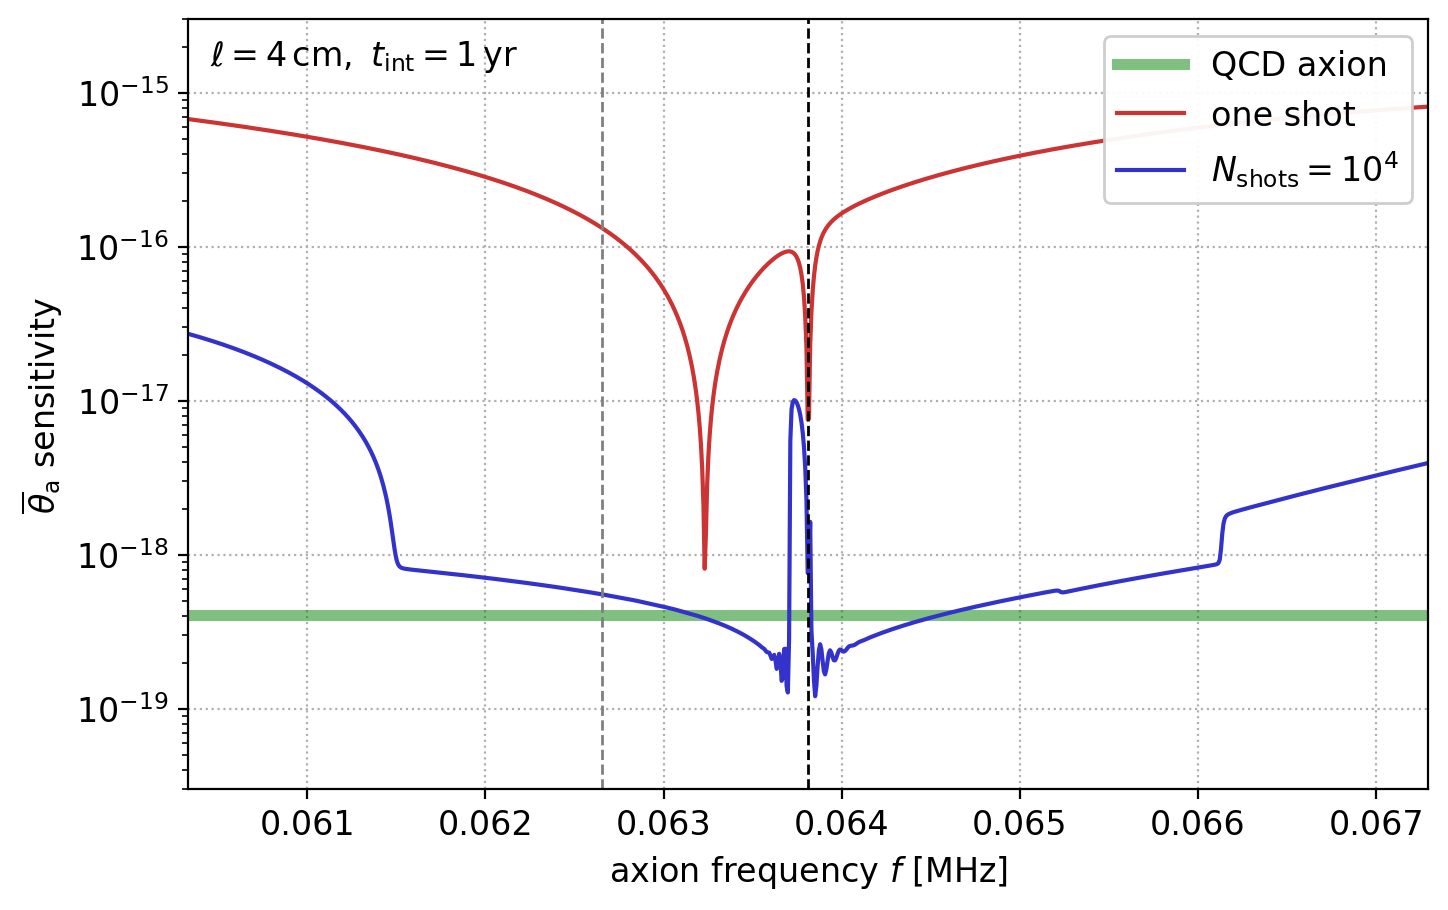

In [7]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot([1e-5,1e15],2*[ThetaAxion],color='green',lw=4,alpha=0.5,label='QCD axion')

ax.plot(vec_omega_plot/(2*np.pi*1e6*Second**-1),vec_theta_sens_shot,color=(0.8,0.2,0.2),label='one shot')
ax.plot(vec_omega_plot/(2*np.pi*1e6*Second**-1),vec_theta_sens_plot,color=(0.2,0.2,0.8),label='$N_\mathrm{shots} = 10^4$')
ax.axvline(omega_res/(2*np.pi*1e6*Second**-1),lw=1,ls='dashed',color='gray')
ax.axvline(omega_0/(2*np.pi*1e6*Second**-1),lw=1,ls='dashed',color='black')

#ax.plot(arr_comb[:,0]/(2*np.pi*Second**-1),arr_comb[:,1],lw=2,alpha=1,color='black',label='combined')
#for n in range(1,n_max+1):
    #ax.plot(arr[n-1,:,0]/(2*np.pi*Second**-1),arr[n-1,:,1],lw=1,alpha=0.8,label=r'$n = $'+str(n));
    #ax.axvline(0.95 * fn_omega_res(l,v,h_11,c_11,beta_11) /(2*np.pi*Second**-1),color='gray',ls='dashed',lw=1) #anti-resonances
    #ax.axvline(fn_omega_res(l,v,h_11,c_11,beta_11) /(2*np.pi*Second**-1),color='gray',ls='dashed',lw=1) #destructive interference
    
ax.set_xscale('linear'); ax.set_yscale('log');
xlim = vec_omega_plot[0]/(2*np.pi*1e6*Second**-1),vec_omega_plot[-1]/(2*np.pi*1e6*Second**-1)
ylim = 3e-20,3e-15
ax.set_xlim(xlim); ax.set_ylim(ylim);
ax.set_xlabel('axion frequency $f ~ [\mathrm{MHz}]$'); ax.set_ylabel(r'$\overline{\theta}_\mathrm{a}$ sensitivity');
ax.grid(ls='dotted');
ax.legend(loc='upper right',ncol=1,framealpha=0.95);
#ax.set_title(r'$\ell = 4\, \mathrm{cm},~t_\mathrm{int} = 1 \, \mathrm{yr}$');
ax.text(xlim[0]*(1.002),ylim[1]*0.5,r'$\ell = 4\, \mathrm{cm},~t_\mathrm{int} = 1 \, \mathrm{yr}$');

In [8]:
arr_comb_hypo_4cm_fund = np.transpose(np.asarray([vec_omega_plot,vec_theta_sens_plot]))

In [9]:
fig.savefig(dir_fig+'sensitivity_QCD_shot_4cm.pdf', bbox_inches='tight', pad_inches = 0)

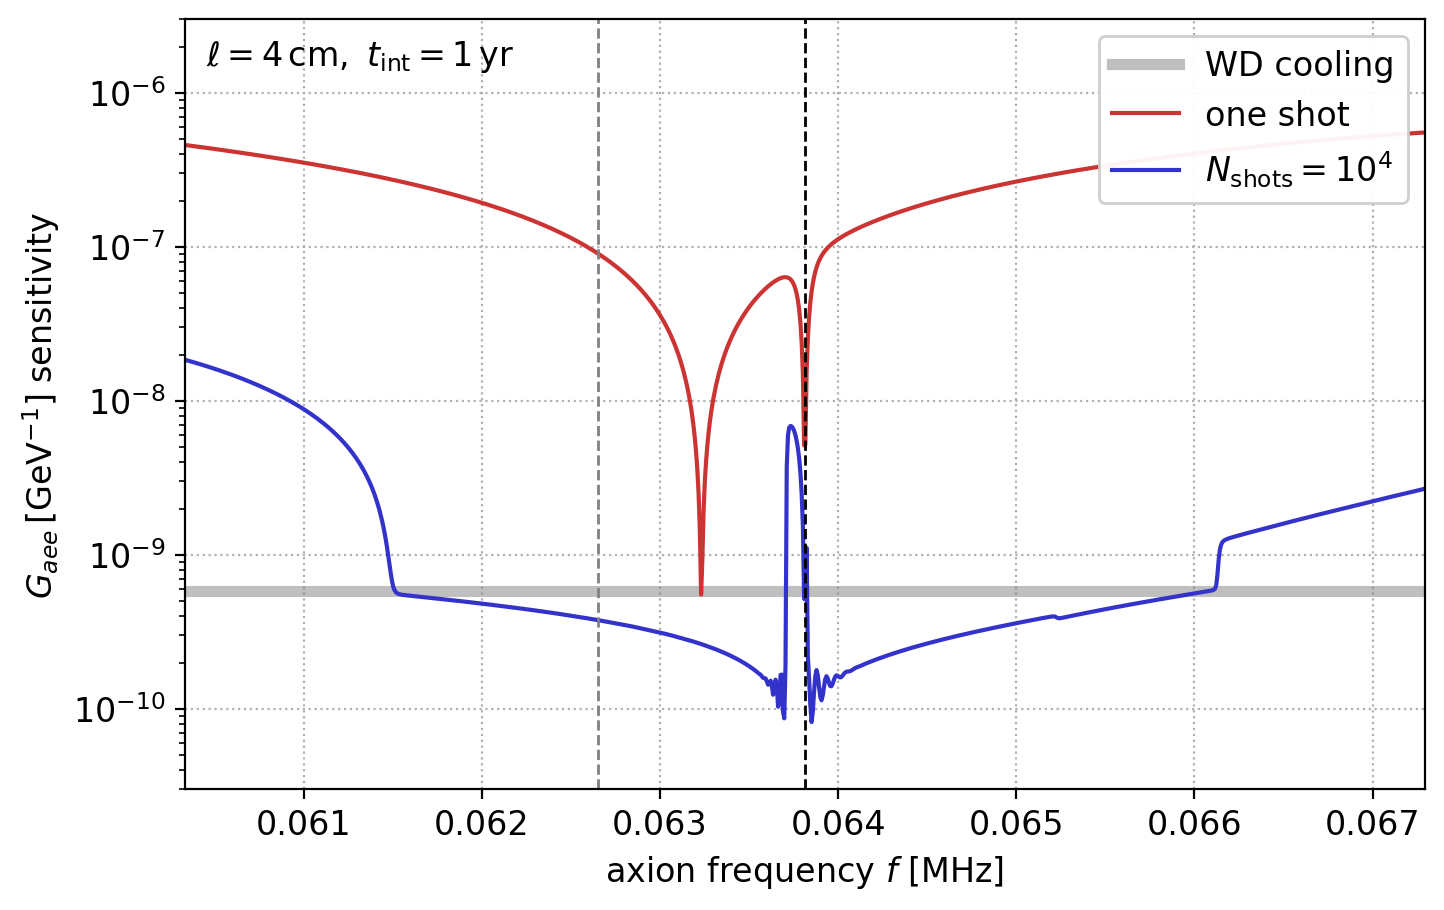

In [10]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot([1e-5,1e15],2*[3*1e-13/MElectron * GeV],color='gray',lw=4,alpha=0.5,label='WD cooling')

ax.plot(vec_omega_plot/(2*np.pi*1e6*Second**-1),vec_G_aee_sens_shot,color=(0.8,0.2,0.2),label='one shot')
ax.plot(vec_omega_plot/(2*np.pi*1e6*Second**-1),vec_G_aee_sens_plot,color=(0.2,0.2,0.8),label='$N_\mathrm{shots} = 10^4$')
ax.axvline(omega_res/(2*np.pi*1e6*Second**-1),lw=1,ls='dashed',color='gray')
ax.axvline(omega_0/(2*np.pi*1e6*Second**-1),lw=1,ls='dashed',color='black')

#ax.plot(arr_comb[:,0]/(2*np.pi*Second**-1),arr_comb[:,1],lw=2,alpha=1,color='black',label='combined')
#for n in range(1,n_max+1):
    #ax.plot(arr[n-1,:,0]/(2*np.pi*Second**-1),arr[n-1,:,1],lw=1,alpha=0.8,label=r'$n = $'+str(n));
    #ax.axvline(0.95 * fn_omega_res(l,v,h_11,c_11,beta_11) /(2*np.pi*Second**-1),color='gray',ls='dashed',lw=1) #anti-resonances
    #ax.axvline(fn_omega_res(l,v,h_11,c_11,beta_11) /(2*np.pi*Second**-1),color='gray',ls='dashed',lw=1) #destructive interference
    
ax.set_xscale('linear'); ax.set_yscale('log');
xlim = vec_omega_plot[0]/(2*np.pi*1e6*Second**-1),vec_omega_plot[-1]/(2*np.pi*1e6*Second**-1)
ylim = 3e-11,3e-6
ax.set_xlim(xlim); ax.set_ylim(ylim);
ax.set_xlabel('axion frequency $f ~ [\mathrm{MHz}]$'); ax.set_ylabel(r'$G_{aee} \, [\mathrm{GeV^{-1}}]$ sensitivity');
ax.grid(ls='dotted');
ax.legend(loc='upper right',ncol=1,framealpha=0.95);
#ax.set_title(r'$\ell = 4\, \mathrm{cm},~t_\mathrm{int} = 1 \, \mathrm{yr}$');
ax.text(xlim[0]*(1.002),ylim[1]*0.5,r'$\ell = 4\, \mathrm{cm},~t_\mathrm{int} = 1 \, \mathrm{yr}$');

## Xylophone (1 efold)

### 4cm

In [11]:
spacing = 3 * (1- omega_res/omega_0); spacing

0.054538287507915784

In [12]:
N_series = 1; N_parallel = 1; 
vec_l = 4*CentiMeter / (1+spacing)**np.arange(0.,np.log(2)/spacing,1.); 
t_int = 10 * Year
N_shots = 10**4
t_shot = t_int / N_shots / len(vec_l)
Q_a = (235 / np.sqrt(2) * KiloMeter / Second)**(-2);
print(vec_l / CentiMeter)

[4.         3.79312923 3.59695733 3.410931   3.23452552 3.06724332 2.90861257 2.75818584 2.61553883 2.48026919 2.35199539 2.23035562 2.11500677]


In [13]:
vec_omega_plot = np.logspace(np.log10((1-spacing)*np.abs(fn_omega_n(vec_l[0],v,1))),np.log10((1+spacing)*np.abs(fn_omega_n(vec_l[-1],v,1))),400)

In [14]:
vec_theta_sens_plot = np.zeros(vec_omega_plot.shape)
for l in tqdm(vec_l):
    omega_0 = np.abs(fn_omega_n(l,v,1)); 
    omega_res = fn_omega_res(l,v,h_11,c_11,beta_11);
    C_c = N_series**-1 * fn_C_crystal_TE_c(l,a,b,beta_11)
    C_1_fid = np.real(C_c)
    L_1_fid = 1/(omega_0**2 * np.real(C_c))
    vec_L_1 = L_1_fid * np.logspace(-3,3,1000)
    vec_C_1 = C_1_fid * np.asarray([0.1,10])
    arr_omega_opt = np.ones((len(vec_L_1),len(vec_C_1))) * np.nan; 
    for i,L_1 in enumerate(vec_L_1):
        L_1_n = L_1 * (1 - 1j * eps_L_1)
        for j,C_1 in enumerate(vec_C_1):
            def fun_Z(omega_frac):
                return np.imag(fn_Z_total(omega_frac * omega_0,l,v,a,b,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1_n, L_2, k_f,N_series,N_parallel))
            if j==0:
                try:
                    arr_omega_opt[i,j] = brentq(f=fun_Z,a=(2*omega_res-omega_0)/omega_0,b=(1-1e-5),xtol=1e-12)
                except ValueError:
                    pass
            elif j==1:
                try:
                    arr_omega_opt[i,j] =  brentq(f=fun_Z,a=1+1e-5,b=(3*omega_0-2*omega_res)/omega_0,xtol=1e-12)
                except ValueError:
                    pass
    fn_L_1_down = interp1d(omega_0 * arr_omega_opt[np.isfinite(arr_omega_opt[:,0]),0],vec_L_1[np.isfinite(arr_omega_opt[:,0])],bounds_error=False,fill_value=np.nan)
    fn_L_1_up = interp1d(omega_0 * arr_omega_opt[np.isfinite(arr_omega_opt[:,1]),1],vec_L_1[np.isfinite(arr_omega_opt[:,1])],bounds_error=False,fill_value=np.nan)
    vec_omega_branch_down = omega_0 * np.linspace(np.nanmin(arr_omega_opt[:,0]),np.nanmax(arr_omega_opt[:,0]),int(N_shots/2))
    vec_omega_branch_up = omega_0 * np.linspace(np.nanmin(arr_omega_opt[:,1]),np.nanmax(arr_omega_opt[:,1]),int(N_shots/2))
    vec_L_1_branch_down = fn_L_1_down(vec_omega_branch_down)
    vec_L_1_branch_up = fn_L_1_up(vec_omega_branch_up)
    vec_L_1_branch = np.concatenate([vec_L_1_branch_down,vec_L_1_branch_up])
    for i,L_1 in enumerate(vec_L_1_branch):
        L_1_n = L_1 * (1 - 1j * eps_L_1)
        if i < N_shots//2:
            C_1 = vec_C_1[0]
        else:
            C_1 = vec_C_1[1]
        vec_theta_sens_shot = fn_theta_sens_opt(t_shot,Q_a,T,vec_omega_plot,l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid,L_i, k_i,C_1,L_1_n,L_2,k_f,eta,
                                            T_2,mu_N,n_N,xi_11,zeta_11,P_nuc,N_series,N_parallel)
        if vec_theta_sens_shot[0] > 0:
            vec_theta_sens_plot += vec_theta_sens_shot**(-4)
        else:
            print(',',end='')
vec_theta_sens_plot = vec_theta_sens_plot**(-1/4)

100%|██████████| 13/13 [00:42<00:00,  3.30s/it]


In [15]:
vec_G_aee_sens_plot = vec_theta_sens_plot / ThetaAxion * xi_11 / xi_11_G_aee

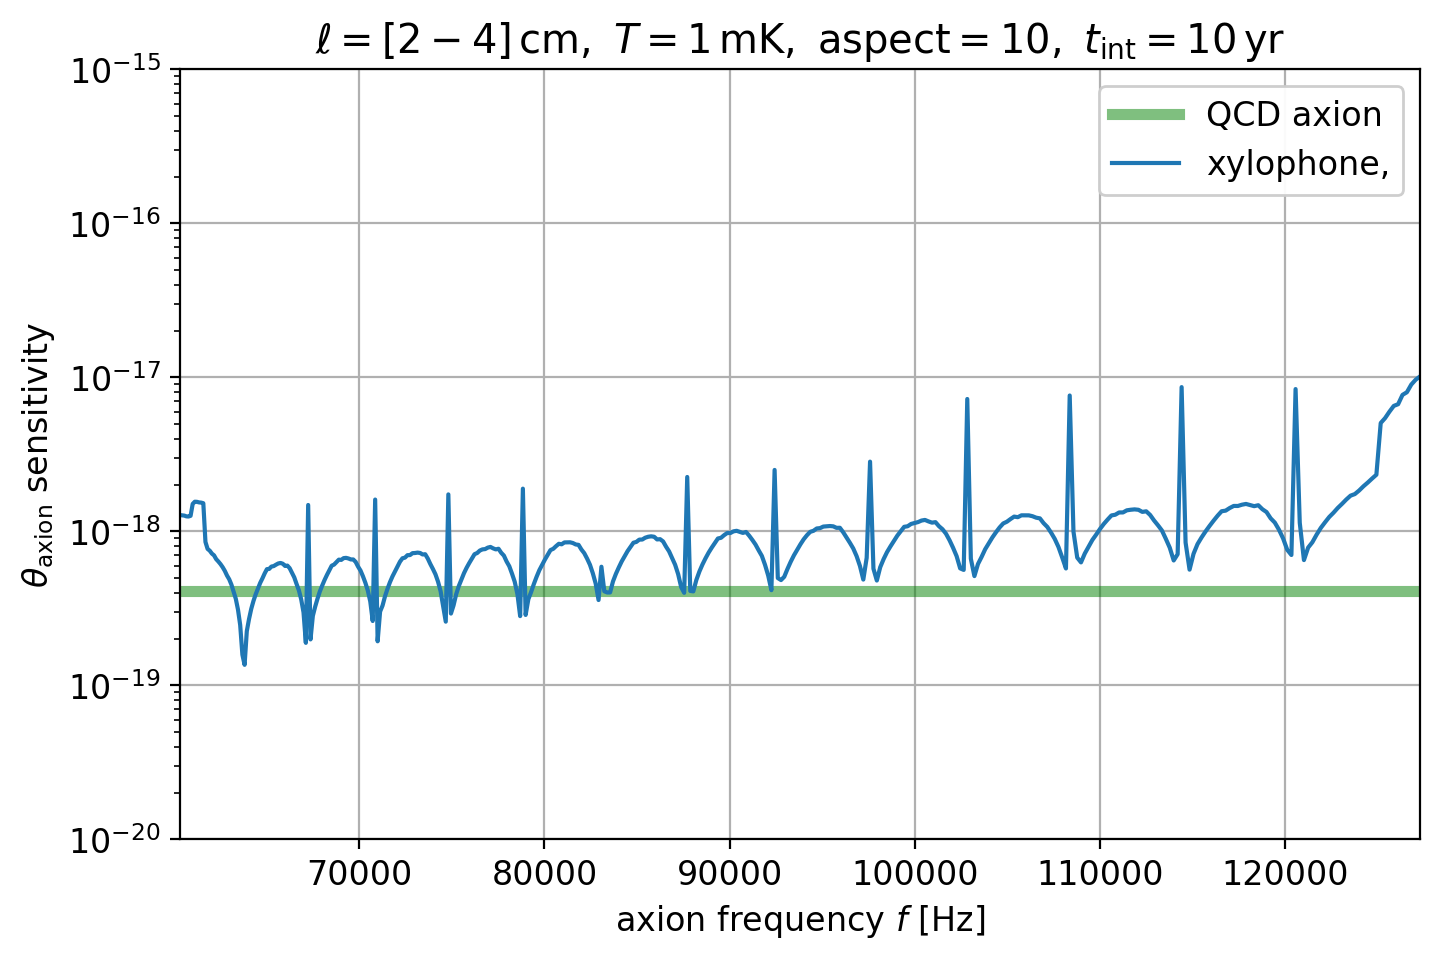

In [16]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot([1e-5,1e15],2*[ThetaAxion],color='green',lw=4,alpha=0.5,label='QCD axion')
ax.plot(vec_omega_plot/(2*np.pi*Second**-1),vec_theta_sens_plot,label='xylophone,')

ax.set_xscale('linear'); ax.set_yscale('log');
ax.set_xlim(vec_omega_plot[0]/(2*np.pi*Second**-1),vec_omega_plot[-1]/(2*np.pi*Second**-1)); ax.set_ylim(1e-20,1e-15);
ax.set_xlabel('axion frequency $f ~ [\mathrm{Hz}]$'); ax.set_ylabel(r'$\theta_\mathrm{axion}$ sensitivity');
ax.grid();
ax.legend(loc='upper right',ncol=1,framealpha=0.95);
ax.set_title(r'$\ell = [2-4]\, \mathrm{cm},~ T = 1\, \mathrm{mK}, ~\mathrm{aspect} = 10, ~t_\mathrm{int} = 10 \, \mathrm{yr}$');

In [17]:
arr_comb_hypo_4cm_xylo = np.transpose(np.asarray([vec_omega_plot,vec_theta_sens_plot]))
arr_comb_hypo_4cm_xylo_G_aee = np.transpose(np.asarray([vec_omega_plot,vec_G_aee_sens_plot]))

### 4mm

In [18]:
spacing = 3 * (1- omega_res/omega_0); spacing

0.05453828750791545

In [19]:
N_series = 64; N_parallel = 4; 
vec_l = 0.4*CentiMeter / (1+spacing)**np.arange(0.,np.log(2)/spacing,1.); 
t_int = 10 * Year
N_shots = 10**4
t_shot = t_int / N_shots / len(vec_l)
Q_a = (235 / np.sqrt(2) * KiloMeter / Second)**(-2);
print(vec_l / CentiMeter)

[0.4        0.37931292 0.35969573 0.3410931  0.32345255 0.30672433 0.29086126 0.27581858 0.26155388 0.24802692 0.23519954 0.22303556 0.21150068]


In [20]:
vec_omega_plot = np.logspace(np.log10((1-spacing)*np.abs(fn_omega_n(vec_l[0],v,1))),np.log10((1+spacing)*np.abs(fn_omega_n(vec_l[-1],v,1))),400)

In [21]:
vec_theta_sens_plot = np.zeros(vec_omega_plot.shape)
for l in tqdm(vec_l):
    omega_0 = np.abs(fn_omega_n(l,v,1)); 
    omega_res = fn_omega_res(l,v,h_11,c_11,beta_11);
    C_c = N_series**-1 * N_parallel * fn_C_crystal_TE_c(l,a,b,beta_11)
    C_1_fid = np.real(C_c)
    L_1_fid = 1/(omega_0**2 * np.real(C_c))
    vec_L_1 = L_1_fid * np.logspace(-3,3,1000)
    vec_C_1 = C_1_fid * np.logspace(-1,1,2)
    arr_omega_opt = np.ones((len(vec_L_1),len(vec_C_1))) * np.nan; 
    for i,L_1 in enumerate(vec_L_1):
        L_1_n = L_1 * (1 - 1j * eps_L_1)
        for j,C_1 in enumerate(vec_C_1):
            def fun_Z(omega_frac):
                return np.imag(fn_Z_total(omega_frac * omega_0,l,v,a,b,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1_n, L_2, k_f,N_series,N_parallel))
            if j==0:
                try:
                    arr_omega_opt[i,j] = brentq(f=fun_Z,a=(2*omega_res-omega_0)/omega_0,b=(1-1e-5),xtol=1e-12)
                except ValueError:
                    pass
            elif j==1:
                try:
                    arr_omega_opt[i,j] =  brentq(f=fun_Z,a=1+1e-5,b=(3*omega_0-2*omega_res)/omega_0,xtol=1e-12)
                except ValueError:
                    pass
    fn_L_1_down = interp1d(omega_0 * arr_omega_opt[np.isfinite(arr_omega_opt[:,0]),0],vec_L_1[np.isfinite(arr_omega_opt[:,0])],bounds_error=False,fill_value=np.nan)
    fn_L_1_up = interp1d(omega_0 * arr_omega_opt[np.isfinite(arr_omega_opt[:,1]),1],vec_L_1[np.isfinite(arr_omega_opt[:,1])],bounds_error=False,fill_value=np.nan)
    vec_omega_branch_down = omega_0 * np.linspace(np.nanmin(arr_omega_opt[:,0]),np.nanmax(arr_omega_opt[:,0]),int(N_shots/2))
    vec_omega_branch_up = omega_0 * np.linspace(np.nanmin(arr_omega_opt[:,1]),np.nanmax(arr_omega_opt[:,1]),int(N_shots/2))
    vec_L_1_branch_down = fn_L_1_down(vec_omega_branch_down)
    vec_L_1_branch_up = fn_L_1_up(vec_omega_branch_up)
    vec_L_1_branch = np.concatenate([vec_L_1_branch_down,vec_L_1_branch_up])
    for i,L_1 in enumerate(vec_L_1_branch):
        L_1_n = L_1 * (1 - 1j * eps_L_1)
        if i < N_shots//2:
            C_1 = vec_C_1[0]
        else:
            C_1 = vec_C_1[1]
        vec_theta_sens_shot = fn_theta_sens_opt(t_shot,Q_a,T,vec_omega_plot,l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid,L_i, k_i,C_1,L_1_n,L_2,k_f,eta,
                                            T_2,mu_N,n_N,xi_11,zeta_11,P_nuc,N_series,N_parallel)
        if vec_theta_sens_shot[0] > 0:
            vec_theta_sens_plot += vec_theta_sens_shot**(-4)
        else:
            print(',',end='')
vec_theta_sens_plot = vec_theta_sens_plot**(-1/4)

100%|██████████| 13/13 [00:41<00:00,  3.18s/it]


In [22]:
vec_G_aee_sens_plot = vec_theta_sens_plot / ThetaAxion * xi_11 / xi_11_G_aee

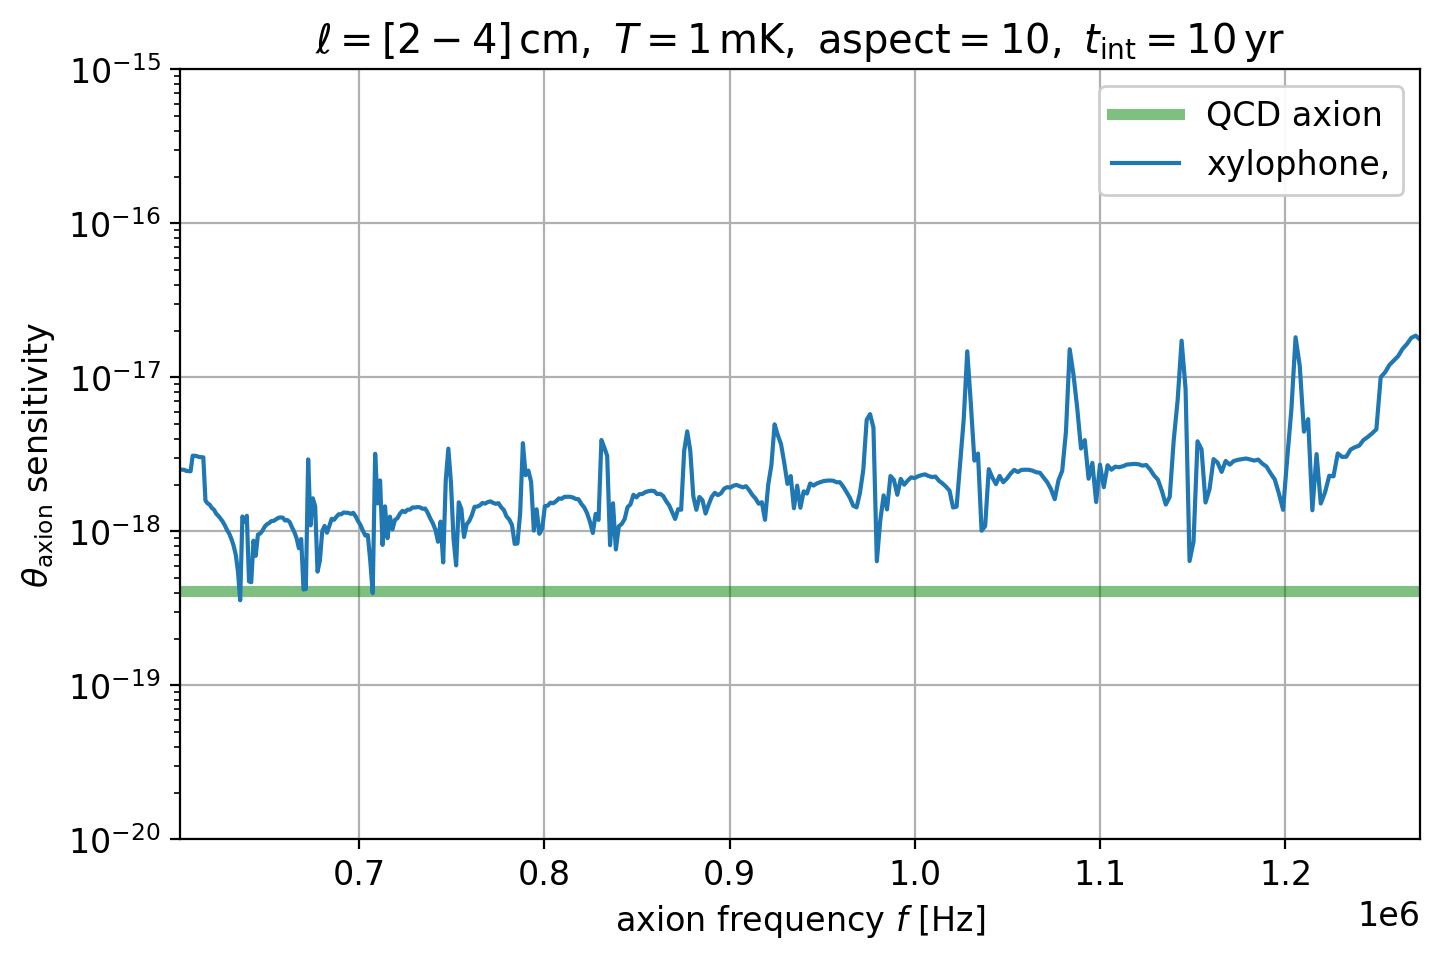

In [23]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot([1e-5,1e15],2*[ThetaAxion],color='green',lw=4,alpha=0.5,label='QCD axion')
ax.plot(vec_omega_plot/(2*np.pi*Second**-1),vec_theta_sens_plot,label='xylophone,')

ax.set_xscale('linear'); ax.set_yscale('log');
ax.set_xlim(vec_omega_plot[0]/(2*np.pi*Second**-1),vec_omega_plot[-1]/(2*np.pi*Second**-1)); ax.set_ylim(1e-20,1e-15);
ax.set_xlabel('axion frequency $f ~ [\mathrm{Hz}]$'); ax.set_ylabel(r'$\theta_\mathrm{axion}$ sensitivity');
ax.grid();
ax.legend(loc='upper right',ncol=1,framealpha=0.95);
ax.set_title(r'$\ell = [2-4]\, \mathrm{cm},~ T = 1\, \mathrm{mK}, ~\mathrm{aspect} = 10, ~t_\mathrm{int} = 10 \, \mathrm{yr}$');

In [24]:
arr_comb_hypo_4mm_xylo = np.transpose(np.asarray([vec_omega_plot,vec_theta_sens_plot]))
arr_comb_hypo_4mm_xylo_G_aee = np.transpose(np.asarray([vec_omega_plot,vec_G_aee_sens_plot]))

## Ultimate

In [25]:
vec_l = np.asarray([40.*CentiMeter,4.*CentiMeter,0.40*CentiMeter,0.01*CentiMeter])
vec_aspect = np.asarray([np.sqrt(0.1),10,20,100])
vec_N_series = np.asarray([1,1,64,256])
vec_N_parallel = np.asarray([1,1,1,32])
vec_M = rho * vec_l**3 * vec_aspect**2 * vec_N_series * vec_N_parallel
print('masses =',vec_M/Kg, 'kilograms')
print([int(i) for i in vec_N_series*vec_N_parallel])

masses = [76.8     76.8     19.6608   0.98304] kilograms
[1, 1, 64, 8192]


In [26]:
t_int = 10 * Year #scanning time per octave
N_shots = 10**4 #number of shots per octave
t_shot = t_int / N_shots 
Q_a = (235 / np.sqrt(2) * KiloMeter / Second)**(-2);

In [27]:
vec_omega_opt = np.zeros(len(vec_l))
vec_band_frac = np.zeros(len(vec_l))
vec_S_opt = np.zeros(len(vec_l))
vec_theta_sens_piezo = np.zeros(len(vec_l))
vec_theta_sens_electro = np.zeros(len(vec_l))

for i_l,l in enumerate(vec_l):
    aspect = vec_aspect[i_l]; a = aspect; b = aspect; 
    N_series = float(vec_N_series[i_l])
    N_parallel = float(vec_N_parallel[i_l])
    omega_0 = np.abs(fn_omega_n(l,v,1));
    omega_res = fn_omega_res(l,v,h_11,c_11,beta_11);
    C_c = N_series**(-1) * N_parallel * fn_C_crystal_TE_c(l,a,b,beta_11)
    L_1_fid = 1/(omega_0**2 * np.real(C_c))
    C_1_fid = np.real(C_c)
    C_1 = 0.1*C_1_fid;
    L_1 = 0.1*L_1_fid * (1 - 1j * eps_L_1);
    def fun_Z(omega_frac):
        return np.imag(fn_Z_total(omega_frac * omega_0,l,v,a,b,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1, L_2, k_f, N_series,N_parallel))
    def fun_S(omega_frac):
        return fn_S_theta_opt(T,omega_frac * omega_0,l,v,a,b,h_11,c_11,beta_11,k2,L_squid, R_squid, L_i, k_i, C_1, L_1, L_2, k_f, eta,
                          T_2, mu_N, n_N, xi_11, zeta_11, P_nuc, N_series,N_parallel)
    def fun_S_bandwidth(omega_frac,omega_opt):
        return fun_S(omega_frac)/fun_S(omega_opt)-2
    try:
        omega_frac = brentq(f=fun_Z,a=(2*omega_res-omega_0)/omega_0,b=(1-1e-10),xtol=1e-15)
        vec_omega_opt[i_l] = omega_0 * omega_frac
        vec_S_opt[i_l] = fun_S(omega_frac)
        omega_frac_1 = brentq(f=fun_S_bandwidth,a=omega_frac*(1-1e-1),b=omega_frac,xtol=1e-15,args=(omega_frac))
        omega_frac_2 = brentq(f=fun_S_bandwidth,a=omega_frac,b=omega_frac*(1+1e-1),xtol=1e-15,args=(omega_frac))
        vec_band_frac[i_l] = (omega_frac_2 - omega_frac_1)/omega_frac
        t_shot = t_int / np.log(2) * vec_band_frac[i_l]
        vec_theta_sens_piezo[i_l] = fn_theta_sens_opt(t_shot,Q_a,T,vec_omega_opt[i_l],l,v,a,b,h_11,c_11,beta_11,k2,L_squid,R_squid,L_i, k_i,C_1,L_1,L_2,k_f,eta,
                                                  T_2,mu_N,n_N,xi_11,zeta_11,P_nuc,N_series,N_parallel)
        vec_theta_sens_electro[i_l] = fn_theta_sens_opt(t_shot,Q_a,T,vec_omega_opt[i_l],l,v,a,b,h_11,c_11,beta_11,k2,L_squid,R_squid,L_i, k_i,C_1,L_1,L_2,k_f,eta,
                                                    T_2,mu_N,n_N,0*xi_11,zeta_11,P_nuc,N_series,N_parallel)

    except ValueError:
        print('err')
        pass
    #print('[l/cm, mass/kg, C_1/picoFarad, L_1/milliHenry, omega_frac] =', 
    #[str(l/CentiMeter)[0:6], str(vec_M[i_l]/Kg)[0:6], str(C_1/(1e-12*Farad))[0:6],str(L_1/(1e-3*Henry))[0:6])

In [28]:
vec_G_aee_sens_piezo = vec_theta_sens_piezo / ThetaAxion * xi_11 / xi_11_G_aee
vec_G_aee_sens_electro = vec_theta_sens_electro / ThetaAxion * xi_11 / xi_11_G_aee

In [29]:
print(np.sqrt(vec_S_opt[:]/(ThetaAxion**2 / Hz)) )
print(vec_theta_sens_piezo/ThetaAxion)
print(vec_theta_sens_electro/ThetaAxion)
print(vec_band_frac)
print(vec_omega_opt/(2*np.pi*1e3*Hz))

[13.89707335  4.39464234  2.74675766  2.07334752]
[0.32087614 0.32087923 0.63421172 2.97390986]
[ 26.55107125  26.55132707  52.47819429 246.08309877]
[1.51361041e-05 1.51355469e-06 1.51361265e-07 4.06544078e-09]
[6.37070142e+00 6.37070142e+01 6.37070142e+02 2.54828066e+04]


In [30]:
arr_sens_ultimate = np.transpose([vec_omega_opt,vec_theta_sens_piezo,vec_theta_sens_electro])
arr_sens_ultimate_G_aee = np.transpose([vec_omega_opt,vec_G_aee_sens_piezo,vec_G_aee_sens_electro])

## Combined

### Plot Prep

#### QCD axion

In [31]:
def fn_fa(ma):
    return 1e12 * GeV * (5.70e-6 * eV)/ma

In [32]:
vec_ma = eV * np.logspace(-14,-6,100)

#### Superradiance

In [33]:
df_SR = pd.read_csv(dir_data+'gluon_SR.csv',header=None,names=['ma [eV]','fa^-1 [GeV^-1]'])
df_SR_proj = pd.read_csv(dir_data+'gluon_SR_proj.csv',header=None,names=['ma [eV]','fa^-1 [GeV^-1]'])

#### Sun

In [34]:
df_sun = pd.read_csv(dir_data+'gluon_sun.csv',header=None,names=['ma [eV]','fa^-1 [GeV^-1]'])
int_sun_log = interp1d(np.log10(df_sun['ma [eV]']),np.log10(df_sun['fa^-1 [GeV^-1]']),bounds_error=False,fill_value='extrapolate')
def int_sun(m):
    return 10**int_sun_log(np.log10(m/eV))

#### BBN

In [35]:
df_bbn = pd.read_csv(dir_data+'gluon_bbn.csv',header=None,names=['ma [eV]','fa^-1 [GeV^-1]'])
int_bbn_log = interp1d(np.log10(df_bbn['ma [eV]']),np.log10(df_bbn['fa^-1 [GeV^-1]']),bounds_error=False,fill_value='extrapolate')
def int_bbn(m):
    return 10**int_bbn_log(np.log10(m/eV))

#### GW

In [36]:
df_GW_high = pd.read_csv(dir_data+'gluon_GW_high.csv',header=None,names=['ma [eV]','fa^-1 [GeV^-1]'])
df_GW_low = pd.read_csv(dir_data+'gluon_GW_low.csv',header=None,names=['ma [eV]','fa^-1 [GeV^-1]'])
int_GW_high_log = interp1d(np.log10(df_GW_high['ma [eV]']),np.log10(df_GW_high['fa^-1 [GeV^-1]']),bounds_error=False,fill_value='extrapolate')
int_GW_low_log = interp1d(np.log10(df_GW_low['ma [eV]']),np.log10(df_GW_low['fa^-1 [GeV^-1]']),bounds_error=False,fill_value='extrapolate')
def int_GW_high(m):
    return 10**int_GW_high_log(np.log10(m/eV))
def int_GW_low(m):
    return 10**int_GW_low_log(np.log10(m/eV))

### Plot (nuclear coupling)

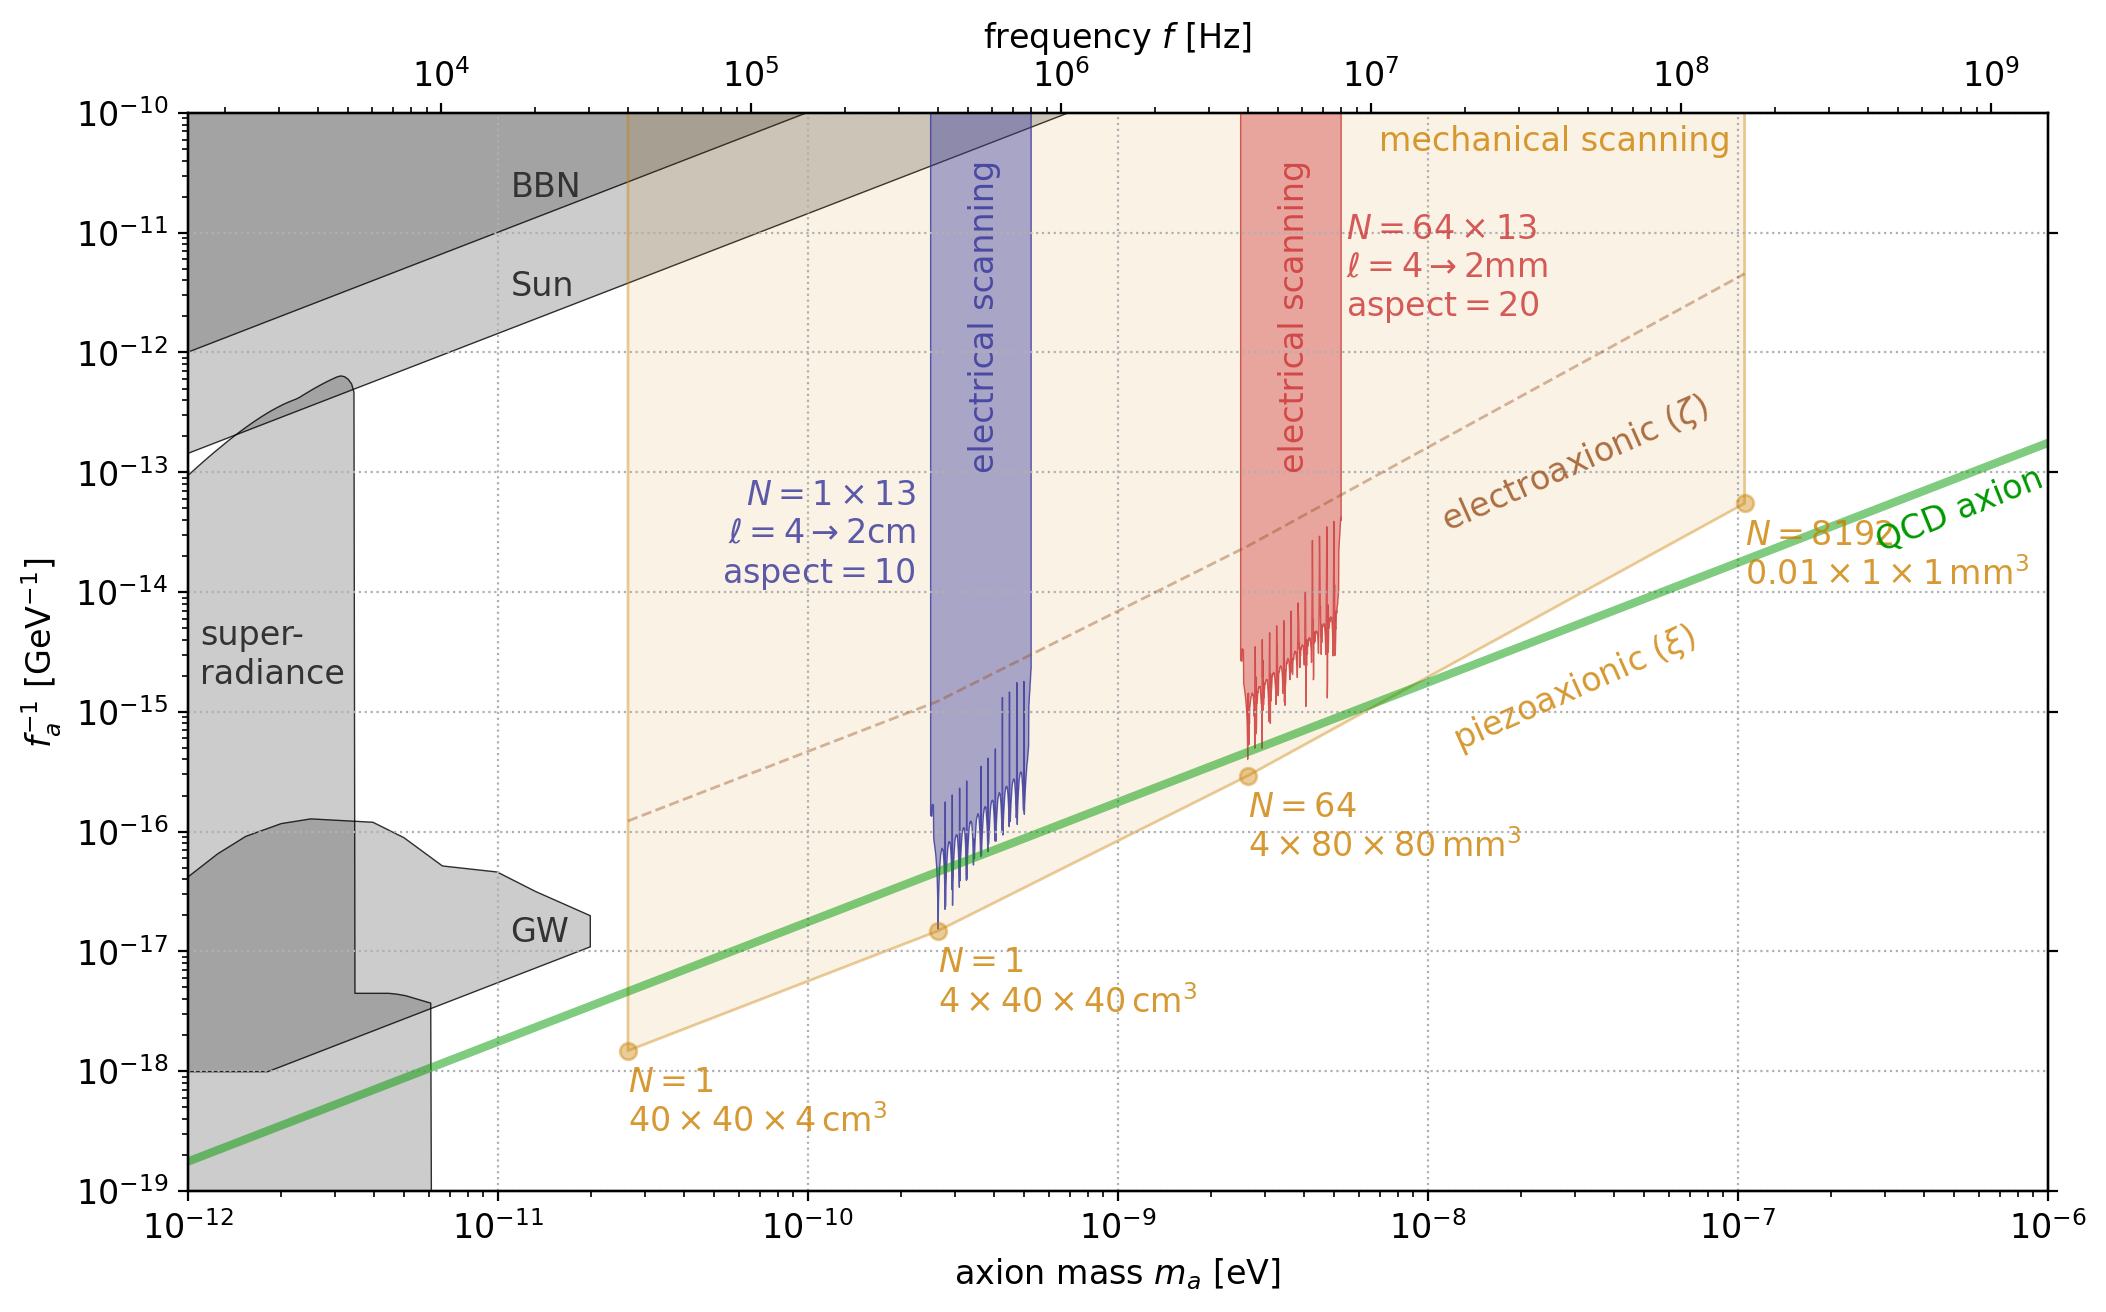

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlim(1e-12,1e-6); ax.set_ylim(1e-19,1e-10)
ax_top = ax.twiny();  ax_top.set_xlim(ax.get_xlim()); ax_top.set_xscale('log');
#ax_top2 = ax.twiny();  ax_top2.set_xlim(ax.get_xlim()); ax_top2.set_xscale('log');
#ax_top2.spines.top.set_position(("axes", 1.1))
ax_right = ax.twinx();  ax_right.set_ylim(ax.get_ylim()); ax_right.set_yscale('log');
ax_right.set_yticklabels([]);
ax.set_xlabel(r'axion mass $m_a~[\mathrm{eV}]$'); ax_top.set_xlabel('frequency $f~[\mathrm{Hz}]$'); ax.set_ylabel('$f_a^{-1}~[\mathrm{GeV}^{-1}]$')
ticks_left_minor = np.outer(10**(np.arange(-19.0,-5)),np.arange(1.,10.,1.)).flatten()
ticks_left_minor = ticks_left_minor[(ax.get_ylim()[0] < ticks_left_minor) & (ticks_left_minor < ax.get_ylim()[1])]
ticks_left_major = 10**(np.arange(-19.0,-9))
ticks_top_minor = np.outer(10**(np.arange(0.0,10)),np.arange(1.,10.,1.)).flatten() * Hz / eV; 
ticks_top_minor = ticks_top_minor[(ax_top.get_xlim()[0] < ticks_top_minor) & (ticks_top_minor < ax_top.get_xlim()[1])]
ticks_top_major = 10**(np.arange(4,10)) * Hz / eV
ax.set_yticks(ticks_left_minor,minor=True); ax.set_yticks(ticks_left_major); 
ax_top.set_xticks([],minor=True); ax_top.set_xticks(ticks_top_minor,minor=True); ax_top.set_xticklabels([],minor=True)
ax_top.set_xticks(ticks_top_major,minor=False); ax_top.set_xticklabels(['$10^4$','$10^5$','$10^6$','$10^7$','$10^8$','$10^9$'],minor=False);
ax.grid(ls='dotted')

ax.fill_between(df_SR['ma [eV]'],df_SR['fa^-1 [GeV^-1]'],edgecolor=(0,0,0,0.8),facecolor=(0,0,0,0.2),lw=0.5)
#ax.fill_between(df_SR_proj['ma [eV]'],df_SR_proj['fa^-1 [GeV^-1]'],edgecolor=(0,0,0,0.8),facecolor=(0,0,0,0.05),lw=0.5,ls='dashed')
vec_m_plot_star = np.logspace(-12,-6,1000) * eV
ax.fill_between(vec_m_plot_star/eV,[int_sun(m) for m in vec_m_plot_star],1,edgecolor=(0,0,0,0.8),facecolor=(0,0,0,0.2),lw=0.5)
ax.fill_between(vec_m_plot_star/eV,[int_bbn(m) for m in vec_m_plot_star],1,edgecolor=(0,0,0,0.8),facecolor=(0,0,0,0.2),lw=0.5)
vec_m_plot_GW = np.logspace(-12,np.log10(np.max(df_GW_high['ma [eV]'])),1000) * eV
ax.fill_between(vec_m_plot_GW/eV,[int_GW_high(m) for m in vec_m_plot_GW],[int_GW_low(m) for m in vec_m_plot_GW],edgecolor=(0,0,0,0.8),facecolor=(0,0,0,0.2),lw=0.5)
ax.plot(vec_ma/eV,1/fn_fa(vec_ma)*GeV,color=(0,0.6,0,0.5),lw=3);

ax.fill_between(arr_sens_ultimate[:,0]/eV,arr_sens_ultimate[:,1]/ThetaAxion/fn_fa(arr_sens_ultimate[:,0]),1,
       ls='solid',lw=1,facecolor=(0.8,0.5,0,0.1),edgecolor=(0.8,0.5,0,0.4))
ax.plot(arr_sens_ultimate[:,0]/eV,arr_sens_ultimate[:,2]/ThetaAxion/fn_fa(arr_sens_ultimate[:,0]),
       ls='dashed',lw=1,color=(0.6,0.3,0.1,0.4))
ax.plot(arr_sens_ultimate[:,0]/eV,arr_sens_ultimate[:,1]/ThetaAxion/fn_fa(arr_sens_ultimate[:,0]),
       ls='none',lw=0,color=(0.8,0.5,0,0.4),marker='.',markersize=12)
ax.fill_between(arr_comb_hypo_4cm_xylo[:,0]/eV,arr_comb_hypo_4cm_xylo[:,1]/ThetaAxion * fn_fa(arr_comb_hypo_4cm_xylo[:,0])**-1,1,
                lw=0.5,ls='solid',edgecolor=(0.2,0.2,0.6,0.8),facecolor=(0.2,0.2,0.6,0.4),label=r'$\mathrm{2cm - 4cm}$, $N = 1$, 10$\,$yr/octave');
ax.fill_between(arr_comb_hypo_4mm_xylo[:,0]/eV,arr_comb_hypo_4mm_xylo[:,1]/ThetaAxion * fn_fa(arr_comb_hypo_4mm_xylo[:,0])**-1,1,
                lw=0.5,ls='solid',edgecolor=(0.8,0.2,0.2,0.8),facecolor=(0.8,0.2,0.2,0.4),label=r'$\mathrm{2mm - 4mm}$, $N = 256$, 10$\,$yr/octave');
text_ultimate=[r'$N=1$'+'\n'+r'$40\times 40 \times 4 \, \mathrm{cm}^3$',r'$N=1$'+'\n'+r'$4\times 40 \times 40 \, \mathrm{cm}^3$',
               r'$N=64$'+'\n'+r'$4 \times 80 \times 80 \, \mathrm{mm}^3$',r'$N=8192$'+'\n'+r'$0.01\times 1 \times 1 \, \mathrm{mm}^3$'];
for i,m in enumerate(arr_sens_ultimate[:,0]):
    ax.text(m/eV,0.75*arr_sens_ultimate[i,1]/ThetaAxion/fn_fa(m),text_ultimate[i],color=(0.8,0.5,0,0.8),va='top')
ax.text(3.0e-8,5e-13,r'electroaxionic ($\zeta$)',color=(0.6,0.3,0.1,0.8),va='top',ha='center',rotation=24)
ax.text(3.0e-8,6e-15,r'piezoaxionic ($\xi$)',color=(0.8,0.5,0,0.8),va='top',ha='center',rotation=24)
ax.text(np.sqrt(2)*arr_sens_ultimate[1,0]/eV,1e-13,'electrical scanning',color=(0.2,0.2,0.6,0.8),rotation=90,va='bottom',ha='center')
ax.text(np.sqrt(2)*arr_sens_ultimate[2,0]/eV,1e-13,'electrical scanning',color=(0.8,0.2,0.2,0.8),rotation=90,va='bottom',ha='center')
ax.text(0.85*arr_sens_ultimate[1,0]/eV,3e-14,r'$N=1\times 13$'+'\n'+r'$\ell = \mathrm{4\rightarrow2 cm}$'+'\n'+r'$\mathrm{aspect} = 10$',color=(0.2,0.2,0.6,0.8),va='center',ha='right')
ax.text(2.075*arr_sens_ultimate[2,0]/eV,5e-12,r'$N=64\times 13$'+'\n'+r'$\ell = \mathrm{4\rightarrow2 mm}$'+'\n'+r'$\mathrm{aspect} = 20$',color=(0.8,0.2,0.2,0.8),va='center',ha='left')
ax.text(0.9*arr_sens_ultimate[3,0]/eV,0.8e-10,'mechanical scanning',color=(0.8,0.5,0,0.8),va='top',ha='right')
ax.text(1.1e-11,2e-11,'BBN',color=(0.2,0.2,0.2),ha='left');
ax.text(1.1e-11,3e-12,'Sun',color=(0.2,0.2,0.2),ha='left');
ax.text(1.1e-12,3e-15,r'super-'+'\n'+'radiance',color=(0.2,0.2,0.2),va='center');
#ax.text(2.8e-12,3e-15,r'$~\rightarrow$ proj',color=(0.2,0.2,0.2),ha='left',va='center')
ax.text(1.1e-11,1.2e-17,'GW',color=(0.2,0.2,0.2),ha='left');
ax.text(2.7e-7,2.2e-14,'QCD axion',color=(0,0.6,0,1),rotation=22);
#ax.legend(loc='lower right');

In [38]:
fig.savefig(dir_fig+'sensitivity_QCD.pdf', bbox_inches='tight', pad_inches = 0)

### Plot (electron coupling)

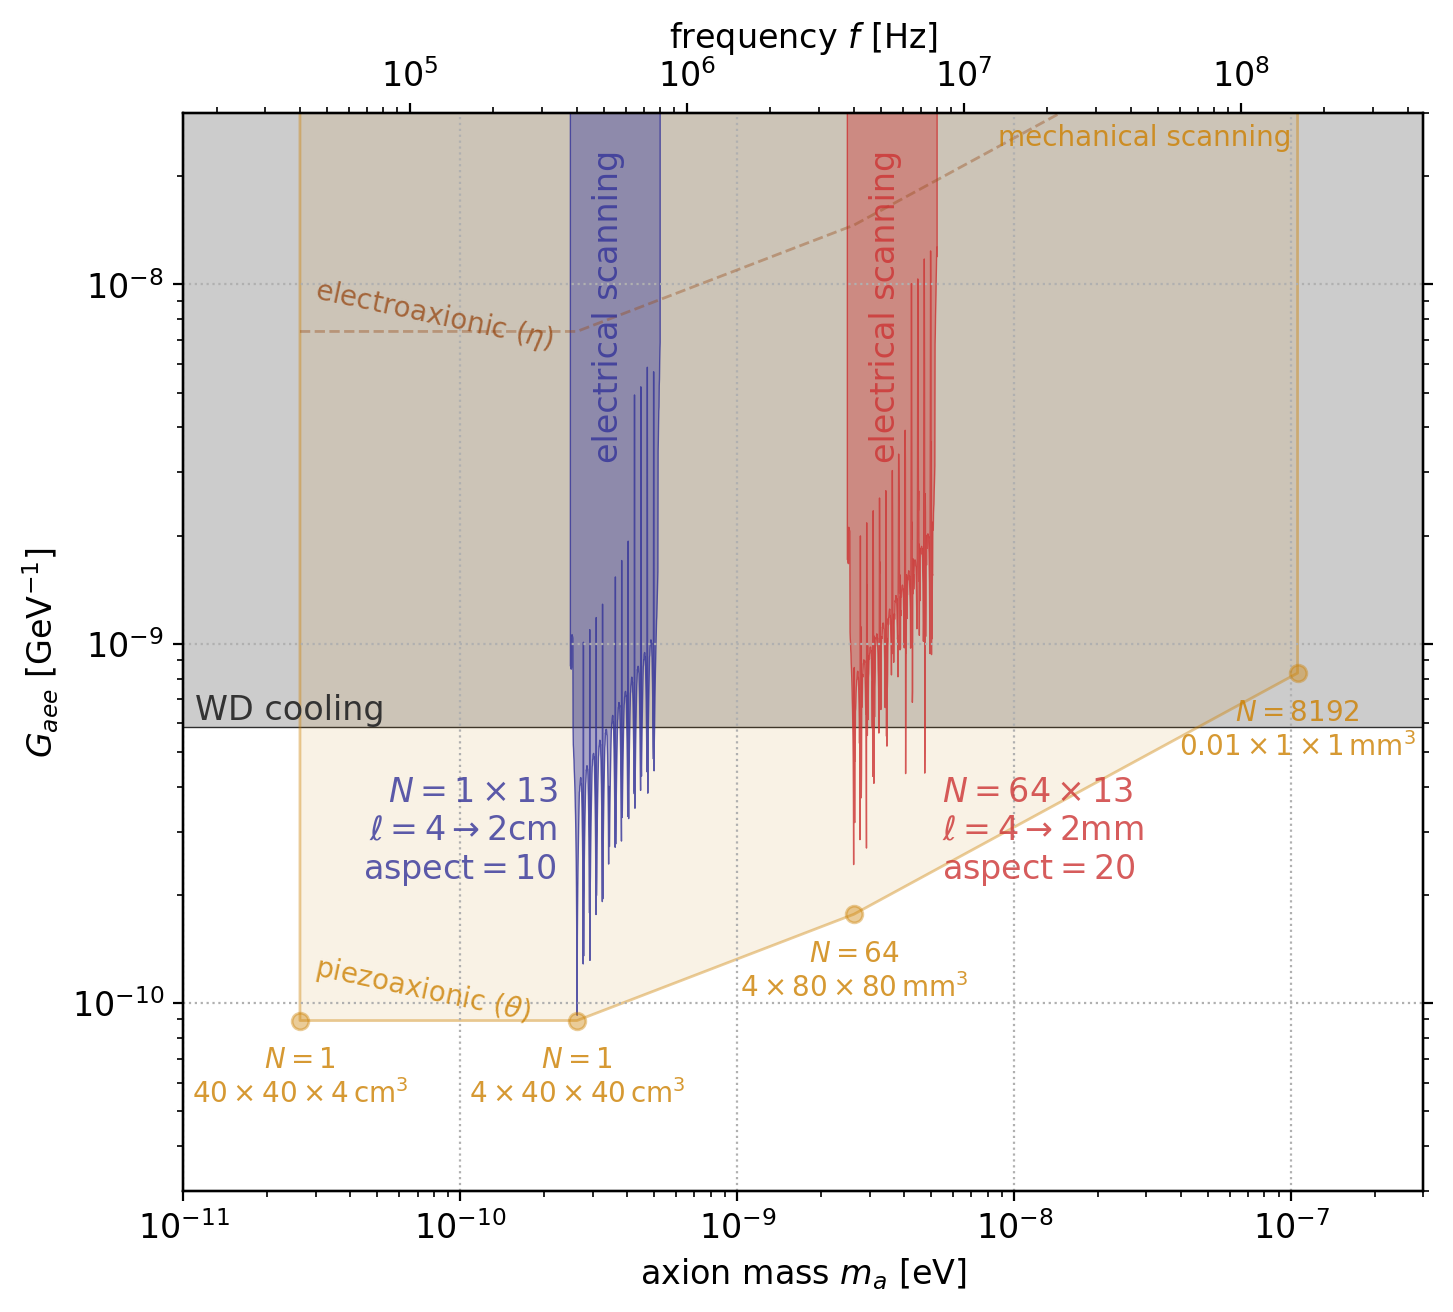

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlim(1e-11,3e-7); ax.set_ylim(3e-11,3e-8)
ax_top = ax.twiny();  ax_top.set_xlim(ax.get_xlim()); ax_top.set_xscale('log');
#ax_top2 = ax.twiny();  ax_top2.set_xlim(ax.get_xlim()); ax_top2.set_xscale('log');
#ax_top2.spines.top.set_position(("axes", 1.1))
ax_right = ax.twinx();  ax_right.set_ylim(ax.get_ylim()); ax_right.set_yscale('log');
ax_right.set_yticklabels([]);
ax.set_xlabel(r'axion mass $m_a~[\mathrm{eV}]$'); ax_top.set_xlabel('frequency $f~[\mathrm{Hz}]$'); ax.set_ylabel('$G_{aee}~[\mathrm{GeV}^{-1}]$')
ticks_left_minor = np.outer(10**(np.arange(-19.0,-5)),np.arange(1.,10.,1.)).flatten()
ticks_left_minor = ticks_left_minor[(ax.get_ylim()[0] < ticks_left_minor) & (ticks_left_minor < ax.get_ylim()[1])]
ticks_left_major = 10**(np.arange(-10.0,-7))
ticks_top_minor = np.outer(10**(np.arange(0.0,10)),np.arange(1.,10.,1.)).flatten() * Hz / eV; 
ticks_top_minor = ticks_top_minor[(ax_top.get_xlim()[0] < ticks_top_minor) & (ticks_top_minor < ax_top.get_xlim()[1])]
ticks_top_major = 10**(np.arange(5,9)) * Hz / eV
ax.set_yticks(ticks_left_minor,minor=True); ax.set_yticks(ticks_left_major); 
ax_top.set_xticks([],minor=True); ax_top.set_xticks(ticks_top_minor,minor=True); ax_top.set_xticklabels([],minor=True)
ax_top.set_xticks(ticks_top_major,minor=False); ax_top.set_xticklabels(['$10^5$','$10^6$','$10^7$','$10^8$'],minor=False);
ax.grid(ls='dotted')

ax.fill_between([1e-12,1e-6],3e-13/MElectron*GeV,1,edgecolor=(0,0,0,0.8),facecolor=(0,0,0,0.2),lw=0.5)

ax.fill_between(arr_sens_ultimate[:,0]/eV,arr_sens_ultimate_G_aee[:,1],1,
       ls='solid',lw=1,facecolor=(0.8,0.5,0,0.1),edgecolor=(0.8,0.5,0,0.4))
ax.plot(arr_sens_ultimate[:,0]/eV,arr_sens_ultimate_G_aee[:,2],
       ls='dashed',lw=1,color=(0.6,0.3,0.1,0.4))
ax.plot(arr_sens_ultimate[:,0]/eV,arr_sens_ultimate_G_aee[:,1],
       ls='none',lw=0,color=(0.8,0.5,0,0.4),marker='.',markersize=12)

ax.fill_between(arr_comb_hypo_4cm_xylo[:,0]/eV,arr_comb_hypo_4cm_xylo_G_aee[:,1],1,
                lw=0.5,ls='solid',edgecolor=(0.2,0.2,0.6,0.8),facecolor=(0.2,0.2,0.6,0.4),label=r'$\mathrm{2cm - 4cm}$, $N = 1$, 10$\,$yr/octave');
ax.fill_between(arr_comb_hypo_4mm_xylo[:,0]/eV,arr_comb_hypo_4mm_xylo_G_aee[:,1],1,
                lw=0.5,ls='solid',edgecolor=(0.8,0.2,0.2,0.8),facecolor=(0.8,0.2,0.2,0.4),label=r'$\mathrm{2mm - 4mm}$, $N = 256$, 10$\,$yr/octave');
text_ultimate=[r'$N=1$'+'\n'+r'$40\times 40 \times 4 \, \mathrm{cm}^3$',r'$N=1$'+'\n'+r'$4\times 40 \times 40 \, \mathrm{cm}^3$',
               r'$N=64$'+'\n'+r'$4 \times 80 \times 80 \, \mathrm{mm}^3$',r'$N=8192$'+'\n'+r'$0.01\times 1 \times 1 \, \mathrm{mm}^3$'];
for i,m in enumerate(arr_sens_ultimate_G_aee[:,0]):
    ax.text(m/eV,0.85*arr_sens_ultimate_G_aee[i,1],text_ultimate[i],color=(0.8,0.5,0,0.8),fontsize=10,va='top',ha='center')
ax.text(2.9e-11,0.63e-8,r'electroaxionic ($\eta$)',fontsize=10,color=(0.6,0.3,0.1,0.8),va='bottom',ha='left',rotation=-12);
ax.text(2.9e-11,0.85e-10,r'piezoaxionic ($\theta$)',fontsize=10,color=(0.8,0.5,0,0.8),va='bottom',ha='left',rotation=-12)
ax.text(1.3*arr_sens_ultimate_G_aee[1,0]/eV,3.2e-9,'electrical scanning',color=(0.2,0.2,0.6,0.8),rotation=90,va='bottom',ha='center')
ax.text(1.3*arr_sens_ultimate_G_aee[2,0]/eV,3.2e-9,'electrical scanning',color=(0.8,0.2,0.2,0.8),rotation=90,va='bottom',ha='center')
ax.text(0.85*arr_sens_ultimate[1,0]/eV,3e-10,r'$N=1\times 13$'+'\n'+r'$\ell = \mathrm{4\rightarrow2 cm}$'+'\n'+r'$\mathrm{aspect} = 10$',color=(0.2,0.2,0.6,0.8),va='center',ha='right')
ax.text(2.075*arr_sens_ultimate[2,0]/eV,3e-10,r'$N=64\times 13$'+'\n'+r'$\ell = \mathrm{4\rightarrow2 mm}$'+'\n'+r'$\mathrm{aspect} = 20$',color=(0.8,0.2,0.2,0.8),va='center',ha='left')
ax.text(1e-7,2.8e-8,'mechanical scanning',fontsize=10,color=(0.8,0.5,0,0.8),va='top',ha='right')
ax.text(1.1e-11,1.05*3e-13/MElectron*GeV,'WD cooling',color=(0.2,0.2,0.2),ha='left');

In [40]:
fig.savefig(dir_fig+'sensitivity_G_aee.pdf', bbox_inches='tight', pad_inches = 0)